Toastmasters scheduling with MIP
---

Try to schedule all the rules of Toastmasters using a MIP approach.

The restrictions are:
- everyone has to do each of the three "main" jobs once
- the three main jobs are repeated 2 or 3 times on a single day
- students should speak "against" a different set of speakers between their two times
- auxiliary jobs should be filled with remaining students, with preference to students who haven't done that job yet

Model 1

- assign a number to each student
- create a N_jobs x M_days schedule. Some days can have one more or less of the main jobs to finish the class
- All numbers in a row (a single day) must be different. (no student has two jobs on a single day)
- All numbers in a column are preferentially different (no student does a job twice)
- Prepared speakers and evaluators must not be the same (an evaluator / speaker pair doesn't compete more than once --- an evaluator / speaker pair doesn't swap roles later, and they don't speak at the same time

Model 2
- assign a binary to each student-job-day combo
- sum student-jobs (sum over a day) is the number of students. Every student does one job each day.
- Nobody should do the same job more than once.
    - sum days for any student-single job is <=1
- Important Speaker roles must be done
    - sum student-impromptu == 1, ditto for other two speaker roles
- be sure students take a leadership role. Some may do roles more times.
    - sum student-leadership-roles-days >=1

I'm digging model 2. Let's see how it goes.

In [1]:
import pulp as pl
import pandas as pd
# import numpy as np
# import os

students2025 = """Hiro
Toka
Rene
Nene
Yuna H.
Rui
Yuna C.
Kazu
Himi
Kokoro
Aika
Sara
Risako
Hanna
Suzuna
Yuriko
George
Yamato
Daisy
Koriki
Miharu
Taisuke""".split('\n')

jobs = {
    "prepared_roles":['prepared1','prepared2','prepared3'],
    "impromptu_roles" :['impromptu1','impromptu2','impromptu3'],
    "evaluator_roles" :['evaluator1','evaluator2','evaluator3'],
    "leadership" : [
        "President",
        "Toastmaster",
        "Table Topics Master",
        "General Evaluator"
    ],
    "aux":[
        "Greeter",
        "Joke Master",
        "Timer",
        "Grammarian and Word of the Day",
        "Ah Counter",
        "Ballot Counter",
        'Sergeant at Arms',
        'Thought of the Day',
        'Stand-in'
    ]
}

last_day_jobs = ['prepared4','evaluator4','impromptu4']

competitive_pairs = [
    'speaker-evaluator',
]

all_jobs = [
        job
        for category in jobs.values()
    for job in category
]

#define the bounds of the problem
students = students2025

no_days = 7
days = range(1, no_days+1)

#create the model
model = pl.LpProblem("Toastmasters", pl.LpMaximize)

###############################################################
# Variables
###############

#binary variables.
# schedule[(student, day, job)] is 1 if and only if the student takes that job that day.
schedule = {
    (student, day, job):pl.LpVariable(
        f"schedule_{student}_{day}_{job}",
        0,
        1,
        cat = 'Binary'
    )
    for student in students
    for day in days
    for job in all_jobs
}

# allow in the schedule for the 22nd students to do their critical jobs
last_day_jobs_schedule = {
    (student, day, job):pl.LpVariable(
        f"schedule_{student}_{day}_{job}",
        0,
        1,
        cat = 'Binary'
    )
    for student in students
    for job in last_day_jobs
    for day in days #the non-last days will be forced zero later.
}

schedule.update(last_day_jobs_schedule)
        

#create a variable to track speaker-evaluator pairs
# This is ordered: studenta is the first in the pair, studentb is the second
competition = {
    (studenta, studentb, pair, day):pl.LpVariable(
        f"competition_{studenta}_{studentb}_{pair}_{day}",
        0,
        1,
        cat = "Binary"
    )
    for studenta in students
    for studentb in students
    for day in days
    for pair in competitive_pairs
}

###############################################################
# Constraints
#################

############################
# single-student constraints
for student in students:
    
    ###################################################
    # each student does any given job only once at most
    for job in all_jobs:
        model += pl.lpSum(
            schedule[student, day, job]
            for day in days
        ) <= 1

    # including the last day.
    for job in last_day_jobs:
        model += pl.lpSum(
            schedule[student, day, job]
            for day in days
        ) <= 1

    ##################################################
    # each student does each of the critical jobs once
    model += pl.lpSum(
        schedule[student, day, job]
        for job in jobs["prepared_roles"]
        for day in days
    ) + schedule[student, 7, 'prepared4'] == 1
    model += pl.lpSum(
        schedule[student, day, job]
        for job in jobs["impromptu_roles"]
        for day in days
    ) + schedule[student, 7, 'impromptu4'] == 1
    model += pl.lpSum(
        schedule[student, day, job]
        for job in jobs["evaluator_roles"]
        for day in days
    ) + schedule[student, 7, 'evaluator4'] == 1

    ################################################
    # each student does at least one leadership role
    model += pl.lpSum(
        schedule[student, day, job]
        for job in jobs['leadership']
        for day in days
    ) >= 1
    
    ####################################################
    # students don't do more than one job on a given day
    for day in days:
        model += pl.lpSum(
            schedule[student, day, job]
            for job in all_jobs
        ) + pl.lpSum(
            schedule[student, day, job]
            for job in last_day_jobs
        ) <= 1

########################
# single-job constraints
for job in all_jobs:
    #every job is filled once and only once each day...
    for day in days[:-1]:
        model += pl.lpSum(
            schedule[student, day, job]
            for student in students
        ) == 1

    #except day 7 which has extra jobs. On that day, make aux jobs optional.
    if job in jobs['aux']:
        model += pl.lpSum(
            schedule[student, days[-1], job]
            for student in students
        ) <= 1
    else:
        model+= pl.lpSum(
            schedule[student, days[-1], job]
            for student in students
        ) == 1



#...including the extras on day 7
for job in last_day_jobs:
    #the last-day jobs filled in on the last day...
    model += pl.lpSum(
        schedule[student, 7, job]
        for student in students
    ) == 1
    #...and the last day only. Nobody has these jobs on earlier days.
    for day in days[:-1]:
        for student in students:
            model += schedule[student, day, job] == 0
        

##############################
# Objective: fill the schedule
model += pl.lpSum(schedule.values())

###############################
# competition based constraints
for student1 in students:

    #students never compete with themselves
    for day in days:
        model += competition[student1, student1, 'speaker-evaluator', day] == 0
    
    for student2 in students:
        if student1 != student2:
            #two given students don't reverse competetive roles
            model += pl.lpSum(
                competition[student1, student2, 'speaker-evaluator', day]
                + competition[student2, student1, 'speaker-evaluator', day]
                for day in days
            ) <= 1

            # a student only competes as many times as they do the job on a given day
            for day in days:
                model += competition[student1, student2, 'speaker-evaluator', day] <= pl.lpSum(
                    schedule[student1, day, job]
                    for job in jobs['prepared_roles']
                )
                model += competition[student1, student2, 'speaker-evaluator', day] <= pl.lpSum(
                    schedule[student2, day, job]
                    for job in jobs['evaluator_roles']
                )
                model += competition[student1, student2, 'speaker-evaluator', day] >= pl.lpSum(
                        schedule[student1, day, speaker_job]
                        for speaker_job in jobs['prepared_roles']
                    ) + pl.lpSum(
                        schedule[student2, day, evaluator_job]
                        for evaluator_job in jobs['evaluator_roles']
                    ) - 1


#############################################################
# Solve
############
model.solve(pl.PULP_CBC_CMD(msg = True))

#############################################################
# Result
############

model_status = pl.LpStatus[model.status]
print(model_status)
assert model_status == 'Optimal', f"Model status: {model_status}"


schedule_df = pd.DataFrame(columns = all_jobs, index = pd.MultiIndex.from_product([days, students], names = ['days','students']))

separator = "-"*32
for day in days:
    # print(f"Day {day}\n{separator}")
    for job in all_jobs:
        for student in students:
            val = schedule[student, day, job].value()
            if val is not None and val > 0.5:
                # print(f"{job}: {student}")
                this_student = student
                schedule_df.loc[(day, this_student), job] = 1
    # print(f"{separator}\n{separator}\n")

schedule_df.fillna(0, inplace=True)

Optimal


C:\Users\David\AppData\Local\Temp\ipykernel_2740\2699356962.py:287: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  schedule_df.fillna(0, inplace=True)


In [2]:
#look at the model schedule variables
schedule_df

prepared1  prepared2  prepared3  impromptu1  impromptu2  \
days students                                                            
1    Hiro              0          0          0           0           0   
     Toka              0          0          0           0           0   
     Rene              0          0          0           0           0   
     Nene              0          0          0           0           0   
     Yuna H.           0          0          0           0           0   
...                  ...        ...        ...         ...         ...   
7    Yamato            0          0          0           1           0   
     Daisy             0          0          0           0           0   
     Koriki            0          0          0           0           0   
     Miharu            0          0          0           0           0   
     Taisuke           0          0          0           0           0   

               impromptu3  evaluator1  evaluator2  evaluator3  President  ...  \
days students                                                             ...   
1    Hiro               0           0           0           1          0  ...   
     Toka               0           0           0           0          0  ...   
     Rene               1           0           0           0          0  ...   
     Nene               0           0           0           0          0  ...   
     Yuna H.            0           1           0           0          0  ...   
...                   ...         ...         ...         ...        ...  ...   
7    Yamato             0           0           0           0          0  ...   
     Daisy              0           0           0           0          1  ...   
     Koriki             0           0           0           0          0  ...   
     Miharu             0           0           0           0          0  ...   
     Taisuke            0           0           0           0          0  ...   

               General Evaluator  Greeter  Joke Master  Timer  \
days students                                                   
1    Hiro                      0        0            0      0   
     Toka                      0        0            0      0   
     Rene                      0        0            0      0   
     Nene                      0        0            0      0   
     Yuna H.                   0        0            0      0   
...                          ...      ...          ...    ...   
7    Yamato                    0        0            0      0   
     Daisy                     0        0            0      0   
     Koriki                    0        1            0      0   
     Miharu                    0        0            0      0   
     Taisuke                   0        0            0      0   

               Grammarian and Word of the Day  Ah Counter  Ballot Counter  \
days students                                                               
1    Hiro                                   0           0               0   
     Toka                                   0           0               0   
     Rene                                   0           0               0   
     Nene                                   0           1               0   
     Yuna H.                                0           0               0   
...                                       ...         ...             ...   
7    Yamato                                 0           0               0   
     Daisy                                  0           0               0   
     Koriki                                 0           0               0   
     Miharu                                 0           0               0   
     Taisuke                                0           0               0   

               Sergeant at Arms  Thought of the Day  Stand-in  
days students                                                  
1    Hiro             

In [3]:
#create new columns for the 4th jobs on day 7
schedule_df[last_day_jobs] = 0

#fill those columns
for student in students:
    for job in last_day_jobs:
        schedule_df.loc[(7, student) ,job] = schedule[student, 7, job].value()



#look at the job sums. Each should be 7 --- all jobs are filled every day
# with an exception of the last day jobs
schedule_df.sum()

prepared1                         7
prepared2                         7
prepared3                         7
impromptu1                        7
impromptu2                        7
impromptu3                        7
evaluator1                        7
evaluator2                        7
evaluator3                        7
President                         7
Toastmaster                       7
Table Topics Master               7
General Evaluator                 7
Greeter                           7
Joke Master                       7
Timer                             7
Grammarian and Word of the Day    7
Ah Counter                        7
Ballot Counter                    6
Sergeant at Arms                  6
Thought of the Day                6
Stand-in                          7
prepared4                         1
evaluator4                        1
impromptu4                        1
dtype: int64

In [4]:
#look at the who is assigned the last day jobs. 
schedule_df.loc[(7,), last_day_jobs]

,prepared4,evaluator4,impromptu4
students,,,
Hiro,0,0,0
Toka,0,0,0
Rene,0,0,0
Nene,0,0,0
Yuna H.,0,0,0
Rui,0,0,0
Yuna C.,0,0,0
Kazu,0,0,0
Himi,0,0,0


In [5]:
# schedule_df.idxmax(axis = 'columns')

# assigned_job = schedule_df.idxmax(axis = 'columns')
# assigned_job

# assigned_job.reset_index(name = 'job')

In [25]:
#create a non- binary schedule. Fill each job per day with a student name.
schedule_by_name = pd.DataFrame( columns = all_jobs, index = days)

# fill in the schedle...
for day in days:
    for student in students:
        for job in all_jobs:
            if schedule_df.loc[(day, student), job] >= 0.5:
                schedule_by_name.loc[day,job] = student
                # print(f"adding {student} to {job} on day {day}")

# ... including the 7th day extras
schedule_by_name[last_day_jobs] = 0

for student in students:
    for job in last_day_jobs:
        if schedule[student, 7, job].value() >= 0.5:
            schedule_by_name.loc[7, job] = student

# schedule_by_name.rename(index = "day")

C:\Users\David\AppData\Local\Temp\ipykernel_2740\2948499033.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Hanna' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  schedule_by_name.loc[7, job] = student
C:\Users\David\AppData\Local\Temp\ipykernel_2740\2948499033.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Suzuna' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  schedule_by_name.loc[7, job] = student
C:\Users\David\AppData\Local\Temp\ipykernel_2740\2948499033.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Miharu' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  schedule_by_name.loc[7, job] = student


In [7]:
[
    schedule["Taisuke", 7, job].value()
    for job in last_day_jobs
]

[0.0, 0.0, 0.0]

In [8]:
schedule_by_name

,prepared1,prepared2,prepared3,impromptu1,impromptu2,impromptu3,evaluator1,evaluator2,evaluator3,President,...,Timer,Grammarian and Word of the Day,Ah Counter,Ballot Counter,Sergeant at Arms,Thought of the Day,Stand-in,prepared4,evaluator4,impromptu4
1,Rui,Sara,Taisuke,Kazu,Risako,Rene,Yuna H.,Aika,Hiro,Himi,...,Yuna C.,Miharu,Nene,Suzuna,Toka,George,Hanna,0,0,0
2,Yuriko,Miharu,Nene,Kokoro,Hanna,Yuna H.,Sara,Rui,George,Rene,...,Yamato,Toka,Hiro,Daisy,Taisuke,Kazu,Koriki,0,0,0
3,Rene,Aika,Yuna H.,Himi,Hiro,Suzuna,Koriki,Yuna C.,Yamato,Kokoro,...,Yuriko,Hanna,Daisy,Risako,Kazu,Nene,Rui,0,0,0
4,Kazu,Suzuna,Daisy,Sara,Nene,Taisuke,Rene,Hanna,Kokoro,Yuna H.,...,Miharu,Yamato,Rui,Hiro,Risako,Koriki,Toka,0,0,0
5,Himi,Yamato,Yuna C.,Koriki,George,Rui,Miharu,Daisy,Toka,Kazu,...,Kokoro,Rene,Sara,Yuriko,Hanna,Taisuke,Hiro,0,0,0
6,George,Toka,Koriki,Yuriko,Aika,Daisy,Taisuke,Kazu,Risako,Yuna C.,...,Yuna H.,Himi,Suzuna,Rene,Kokoro,Rui,Yamato,0,0,0
7,Risako,Hiro,Kokoro,Yamato,Toka,Yuna C.,Nene,Yuriko,Himi,Daisy,...,Sara,Aika,Yuna H.,NaN,NaN,NaN,George,Hanna,Suzuna,Miharu


In [9]:
sch = [
    pd.unique(schedule_by_name.loc[day]).astype(str)
    for day in days
]

In [10]:
[ len(set(names)) for names in sch ]

[23, 23, 23, 23, 23, 23, 23]

In [11]:
len(schedule_by_name.columns)

25

In [12]:
#look at the whole finished product.
pd.options.display.max_columns = 30

schedule_by_name

,prepared1,prepared2,prepared3,impromptu1,impromptu2,impromptu3,evaluator1,evaluator2,evaluator3,President,Toastmaster,Table Topics Master,General Evaluator,Greeter,Joke Master,Timer,Grammarian and Word of the Day,Ah Counter,Ballot Counter,Sergeant at Arms,Thought of the Day,Stand-in,prepared4,evaluator4,impromptu4
1,Rui,Sara,Taisuke,Kazu,Risako,Rene,Yuna H.,Aika,Hiro,Himi,Koriki,Kokoro,Yamato,Daisy,Yuriko,Yuna C.,Miharu,Nene,Suzuna,Toka,George,Hanna,0,0,0
2,Yuriko,Miharu,Nene,Kokoro,Hanna,Yuna H.,Sara,Rui,George,Rene,Suzuna,Yuna C.,Risako,Aika,Himi,Yamato,Toka,Hiro,Daisy,Taisuke,Kazu,Koriki,0,0,0
3,Rene,Aika,Yuna H.,Himi,Hiro,Suzuna,Koriki,Yuna C.,Yamato,Kokoro,Toka,Sara,George,Taisuke,Miharu,Yuriko,Hanna,Daisy,Risako,Kazu,Nene,Rui,0,0,0
4,Kazu,Suzuna,Daisy,Sara,Nene,Taisuke,Rene,Hanna,Kokoro,Yuna H.,Himi,Aika,Yuriko,Yuna C.,George,Miharu,Yamato,Rui,Hiro,Risako,Koriki,Toka,0,0,0
5,Himi,Yamato,Yuna C.,Koriki,George,Rui,Miharu,Daisy,Toka,Kazu,Aika,Risako,Nene,Yuna H.,Suzuna,Kokoro,Rene,Sara,Yuriko,Hanna,Taisuke,Hiro,0,0,0
6,George,Toka,Koriki,Yuriko,Aika,Daisy,Taisuke,Kazu,Risako,Yuna C.,Hanna,Hiro,Miharu,Sara,Nene,Yuna H.,Himi,Suzuna,Rene,Kokoro,Rui,Yamato,0,0,0
7,Risako,Hiro,Kokoro,Yamato,Toka,Yuna C.,Nene,Yuriko,Himi,Daisy,Rene,Taisuke,Rui,Koriki,Kazu,Sara,Aika,Yuna H.,NaN,NaN,NaN,George,Hanna,Suzuna,Miharu


Evaluation
===

Do the kinds of checks a student would do when receiving a schedule.

In [13]:
#remind ourselves of the students involved
students

['Hiro',
 'Toka',
 'Rene',
 'Nene',
 'Yuna H.',
 'Rui',
 'Yuna C.',
 'Kazu',
 'Himi',
 'Kokoro',
 'Aika',
 'Sara',
 'Risako',
 'Hanna',
 'Suzuna',
 'Yuriko',
 'George',
 'Yamato',
 'Daisy',
 'Koriki',
 'Miharu',
 'Taisuke']

In [14]:
#swap the indices of the dataframe. for a moment, just to see it.
schedule_df.swaplevel('days', 'students').loc[("Hiro",)]

C:\Users\David\AppData\Local\Temp\ipykernel_2740\3199427451.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  schedule_df.swaplevel('days', 'students').loc[("Hiro",)]


,prepared1,prepared2,prepared3,impromptu1,impromptu2,impromptu3,evaluator1,evaluator2,evaluator3,President,Toastmaster,Table Topics Master,General Evaluator,Greeter,Joke Master,Timer,Grammarian and Word of the Day,Ah Counter,Ballot Counter,Sergeant at Arms,Thought of the Day,Stand-in,prepared4,evaluator4,impromptu4
days,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
#interpret the schedule dataframe for a single student. Print or view a single student's schedule.

separator = "-"*64

def print_schedule(student_name, df = schedule_df):
    """
        Print the student's schedule.
    """
    df_swap = schedule_df.swaplevel("days","students")
    df_student = df_swap.loc[(student,)]
    for day in df_student.index:
        for job in df_student:
            if df_student.loc[day, job] == 1:
                print(job)
        
    return None

def my_schedule(student_name, df = schedule_df):
    """
    get the student's schedule
    """
    jobs = []
    df_swap = schedule_df.swaplevel("days","students")
    df_student = df_swap.loc[(student,)]
    for day in df_student.index:
        for job in df_student:
            if df_student.loc[day, job] == 1:
                jobs.append(job)
    return jobs

#test out the schedule viewer
print_schedule("Sara")

prepared3
Sergeant at Arms
Greeter
impromptu3
Thought of the Day
evaluator1
Table Topics Master


C:\Users\David\AppData\Local\Temp\ipykernel_2740\1198133664.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_student = df_swap.loc[(student,)]


In [16]:

#print out everyone's schedules
for student in students:
    print(f"{separator}\n{student}\n")
    print_schedule(student)
    print("\n")

----------------------------------------------------------------
Hiro

evaluator3
Ah Counter
impromptu2
Ballot Counter
Stand-in
Table Topics Master
prepared2


----------------------------------------------------------------
Toka

Sergeant at Arms
Grammarian and Word of the Day
Toastmaster
Stand-in
evaluator3
prepared2
impromptu2


----------------------------------------------------------------
Rene

impromptu3
President
prepared1
evaluator1
Grammarian and Word of the Day
Ballot Counter
Toastmaster


----------------------------------------------------------------
Nene

Ah Counter
prepared3
Thought of the Day
impromptu2
General Evaluator
Joke Master
evaluator1


----------------------------------------------------------------
Yuna H.

evaluator1
impromptu3
prepared3
President
Greeter
Timer
Ah Counter


----------------------------------------------------------------
Rui

prepared1
evaluator2
Stand-in
Ah Counter
impromptu3
Thought of the Day
General Evaluator


------------------------

C:\Users\David\AppData\Local\Temp\ipykernel_2740\1198133664.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_student = df_swap.loc[(student,)]


In [17]:
from numpy import intersect1d

key_roles = ['impromptu', 'evaluator','prepared']

for student in students:
    #cut the numbers off the roles to check
    sched = my_schedule(student)
    short_sched = [ #cut off the rightmost character in each role (to chop the numbers off from impromptu, etc
        role[:-1]        
        for role in sched
    ]
    #does every student have a full schedule?
    assert len(sched) == len(days)
    #does every student have a different role each day?
    assert len(sched) == len(set(sched))
    #does every student do "impromptu", "evaluator", and "prepared" roles once and only once?
    for role in key_roles:
        assert role in short_sched, f"{role} not in {student}'s schedule"
    #does every student do one of the leadership roles?
    did_leadership = False
    for role in jobs['leadership']:
        did_leadership = did_leadership or role in sched
    assert did_leadership, f"{student} didn't do a leadership role"

    #does any student compete with another more than once?
    summation = 0
    # for studentb in students:
    #     if student != studentb:
    #            summation

C:\Users\David\AppData\Local\Temp\ipykernel_2740\1198133664.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_student = df_swap.loc[(student,)]


In [ ]:
# create a 
def get_competitors(student, df = schedule_df)
    for day in days:
        df.loc[(day, student)]

In [26]:
schedule_by_name

,prepared1,prepared2,prepared3,impromptu1,impromptu2,impromptu3,evaluator1,evaluator2,evaluator3,President,Toastmaster,Table Topics Master,General Evaluator,Greeter,Joke Master,Timer,Grammarian and Word of the Day,Ah Counter,Ballot Counter,Sergeant at Arms,Thought of the Day,Stand-in,prepared4,evaluator4,impromptu4
1,Rui,Sara,Taisuke,Kazu,Risako,Rene,Yuna H.,Aika,Hiro,Himi,Koriki,Kokoro,Yamato,Daisy,Yuriko,Yuna C.,Miharu,Nene,Suzuna,Toka,George,Hanna,0,0,0
2,Yuriko,Miharu,Nene,Kokoro,Hanna,Yuna H.,Sara,Rui,George,Rene,Suzuna,Yuna C.,Risako,Aika,Himi,Yamato,Toka,Hiro,Daisy,Taisuke,Kazu,Koriki,0,0,0
3,Rene,Aika,Yuna H.,Himi,Hiro,Suzuna,Koriki,Yuna C.,Yamato,Kokoro,Toka,Sara,George,Taisuke,Miharu,Yuriko,Hanna,Daisy,Risako,Kazu,Nene,Rui,0,0,0
4,Kazu,Suzuna,Daisy,Sara,Nene,Taisuke,Rene,Hanna,Kokoro,Yuna H.,Himi,Aika,Yuriko,Yuna C.,George,Miharu,Yamato,Rui,Hiro,Risako,Koriki,Toka,0,0,0
5,Himi,Yamato,Yuna C.,Koriki,George,Rui,Miharu,Daisy,Toka,Kazu,Aika,Risako,Nene,Yuna H.,Suzuna,Kokoro,Rene,Sara,Yuriko,Hanna,Taisuke,Hiro,0,0,0
6,George,Toka,Koriki,Yuriko,Aika,Daisy,Taisuke,Kazu,Risako,Yuna C.,Hanna,Hiro,Miharu,Sara,Nene,Yuna H.,Himi,Suzuna,Rene,Kokoro,Rui,Yamato,0,0,0
7,Risako,Hiro,Kokoro,Yamato,Toka,Yuna C.,Nene,Yuriko,Himi,Daisy,Rene,Taisuke,Rui,Koriki,Kazu,Sara,Aika,Yuna H.,NaN,NaN,NaN,George,Hanna,Suzuna,Miharu


In [69]:
last_day_jobs

['prepared4', 'evaluator4', 'impromptu4']

In [72]:
competitors = dict(zip(students,[[]]*len(students)))

for day, names in schedule_by_name.iterrows():
    for role in jobs["prepared_roles"]:
        assigned_student = names[role]
        competitors.update({
            assigned_student: competitors[assigned_student] + schedule_by_name.loc[day, jobs["evaluator_roles"]].to_list()
        })

last_day_extra_speaker = schedule_by_name.loc[days[-1], 'prepared4']
competitors.update({
    last_day_extra_speaker: competitors[last_day_extra_speaker] + [schedule_by_name.loc[days[-1], 'evaluator4']]
})

In [73]:
competitors

{'Hiro': ['Nene', 'Yuriko', 'Himi'],
 'Toka': ['Taisuke', 'Kazu', 'Risako'],
 'Rene': ['Koriki', 'Yuna C.', 'Yamato'],
 'Nene': ['Sara', 'Rui', 'George'],
 'Yuna H.': ['Koriki', 'Yuna C.', 'Yamato'],
 'Rui': ['Yuna H.', 'Aika', 'Hiro'],
 'Yuna C.': ['Miharu', 'Daisy', 'Toka'],
 'Kazu': ['Rene', 'Hanna', 'Kokoro'],
 'Himi': ['Miharu', 'Daisy', 'Toka'],
 'Kokoro': ['Nene', 'Yuriko', 'Himi'],
 'Aika': ['Koriki', 'Yuna C.', 'Yamato'],
 'Sara': ['Yuna H.', 'Aika', 'Hiro'],
 'Risako': ['Nene', 'Yuriko', 'Himi'],
 'Hanna': ['Suzuna'],
 'Suzuna': ['Rene', 'Hanna', 'Kokoro'],
 'Yuriko': ['Sara', 'Rui', 'George'],
 'George': ['Taisuke', 'Kazu', 'Risako'],
 'Yamato': ['Miharu', 'Daisy', 'Toka'],
 'Daisy': ['Rene', 'Hanna', 'Kokoro'],
 'Koriki': ['Taisuke', 'Kazu', 'Risako'],
 'Miharu': ['Sara', 'Rui', 'George'],
 'Taisuke': ['Yuna H.', 'Aika', 'Hiro']}

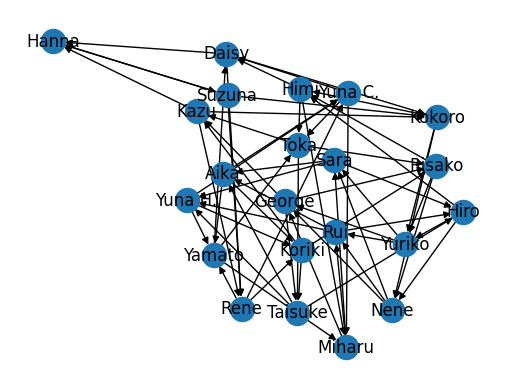

In [74]:
import networkx as nx

edges = []
for student in students:
    for competing_student in competitors[student]:
        edges.append([student, competing_student])

g = nx.from_edgelist(edges, create_using = nx.DiGraph)
g_pos = nx.spring_layout(g)

nx.draw_networkx_labels(g, g_pos, labels = {node:node for node in g.nodes()})
nx.draw(g, pos = g_pos)

